### 5.误差反向传播

In [4]:
import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.append('./book_material')
from common.functions import *
from common.gradient import *
##计算图乘法层
class MulLayer:
    def __init__(self):
        self.x=None
        self.y=None
    def forward(self,x,y):
        self.x=x
        self.y=y
        out=x*y
        return out
    def backward(self,dout):
        dx=dout*self.y
        dy=dout*self.x
        return dx,dy
##加法层
class AddLayer:
    def __init__(self):
        pass
    def forward(self, x, y):
        out = x + y
        return out
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy

In [2]:
apple=100
apple_num=2
orange=150
orange_num=3
tax=1.1
##layer
mul_apple_layer=MulLayer()
mul_orange_layer=MulLayer()
add_apple_orange_layer=AddLayer()
mul_tax_layer=MulLayer()
##foward
apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
all_price=add_apple_orange_layer.forward(apple_price, orange_price)
price=mul_tax_layer.forward(all_price,tax)
dprice=1
dall_price,dtax=mul_tax_layer.backward(dprice)
dapple_price,dorange_price=add_apple_orange_layer.backward(dall_price)
dapple,dapple_num=mul_apple_layer.backward(dapple_price)
dorange,dorange_num=mul_orange_layer.backward(dorange_price)
print(price) # 715
print(dapple_num, dapple, dorange, dorange_num, dtax) # 110 2.2 3.3 165 650

715.0000000000001
110.00000000000001 2.2 3.3000000000000003 165.0 650


In [3]:
class ReLu:
    def __init__(self):
        self.mask=None
    def forward(self,x):
        self.mask=(x>0)
        out=x*self.mask
        return out
    def backward(self,dout):
        dx=dout * self.mask
        return dx

In [4]:
class Sigmoid:
    def __init__(self):
        self.out = None
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

In [5]:
class Affine:
    def __init__(self,W, b):
        self.W=W
        self.b=b
        self.x=None
        self.dW=None
        self.db=None
    def forward(self,x):
        self.x=x
        out = np.dot(x,self.W)+self.b
        
        return out

    def backward(self,dout):
        dx=np.dot(dout,self.W.T)
        dW=np.dot(self.x.T,dout)
        db=dout.sum(axis=0)


In [6]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 损失
        self.y = None    # softmax的输出
        self.t = None    # 监督数据（one-hot vector）
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y-self.t)/batch_size
        return dx

# 两层神经网络

In [7]:
import sys,os
from book_material.common.functions import  *
from book_material.common.gradient import *
from book_material.common.layers import *
import numpy as np
from collections import OrderedDict

In [32]:
class TwoLayerNet:
    def __init__(self,input_size,hidden_size,output_size,weight_init_std=0.01):
        ##初始化权重
        self.params={}
        self.params['W1']=weight_init_std*np.random.randn(input_size,hidden_size)
        self.params['b1']=np.zeros(hidden_size)
        self.params['W2']=weight_init_std*np.random.randn(hidden_size,output_size)
        self.params['b2']=np.zeros(output_size)
        ###生成层
        self.layers = OrderedDict()
        self.layers['Affine1']=Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    ## x输入数据 t监督数据
    def loss(self,x,t):
        y=self.predict(x)
        return self.lastLayer.forward(y,t)
    def accuracy(self,x,t):
        y=self.predict(x)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        result=np.argmax(y,axis=1)
        return np.sum(result==t)/float(x.shape[0])
    def numerical_gradient(self,x,t):
        loss_W = lambda W: self.loss(x, t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads
        
    def gradient(self,x,t):
        self.loss(x,t)
        dout=1
        dout=self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for i in layers:
            dout=i.backward(dout)
        # 设定
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        return grads

In [33]:
import sys, os
import numpy as np
from dataset.mnist import load_mnist
# 读入数据b
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label = True)

In [34]:
# network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
# ###验证两种梯度下降的差异
# choice=np.random.choice(np.arange(10000), size=100, replace=True)
# g=network.gradient(x_test[choice],t_test[choice])
# n=network.numerical_gradient(x_test[choice],t_test[choice])

In [53]:
###误差反向传播
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

In [54]:
train_shape=x_train.shape[0]
num=300
learn_rate=0.1
loss_list=[]
test_accuracy_list=[]


In [55]:
for i in range(num):
    batch_mask=np.random.choice(np.arange(x_train.shape[0]), size=100, replace=True)
    grads=network.gradient(x_train[batch_mask],t_train[batch_mask])
    for key in network.params.keys():
        network.params[key] -= learn_rate*grads[key]


    loss_list.append(network.loss(x_train[batch_mask],t_train[batch_mask]))
    test_accuracy_list.append(network.accuracy(x_test,t_test))

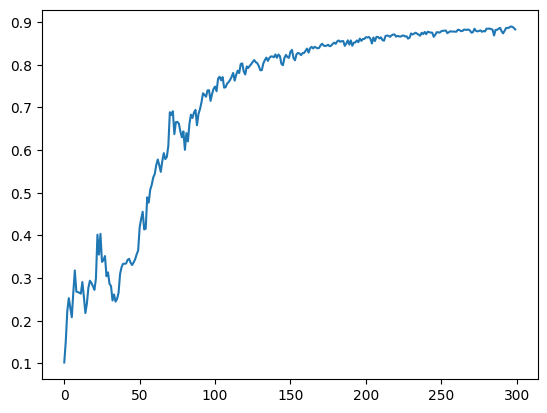

In [57]:
plt.plot(np.arange(len(test_accuracy_list)),test_accuracy_list)

In [58]:
t=[[1,2,3],[1,2,3]]